# Employees Productivity Prediction using Random Forest Classifier
&emsp;This [Dataquest guided project](https://app.dataquest.io/c/140/m/755/guided-project%3A-predicting-employee-productivity-using-tree-models/1/introduction) uses a dataset from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees) to practise the application of Random Forest Classifier. Although instructions are given as it is a guided project from Dataquest, approach and methods for reaching the objective, predicting the productivity of employees, could be different.

1. [Dataset/Libraries Initialization](#initial)
2. [Exploratory Data Analysis](#eda)  
&emsp;2.1 [Missing Values](#miss)  
&emsp;2.2 [Numeric Features](#numeric)  
&emsp;&emsp;2.2.1 [Outliers & Misinformation](#outlier)

# Dataset/Libraries Initialization<a id='initial'></a>

In [371]:
# array and dataframe
import numpy as np
import pandas as pd
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
# supervised machine learning algorithm and cross validation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# metrics
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [372]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
# fetch dataset
productivity_prediction_of_garment_employees = fetch_ucirepo(id=597)
# data (as pandas dataframes)
X = productivity_prediction_of_garment_employees.data.features
y = productivity_prediction_of_garment_employees.data.targets
Xy = pd.concat([X, y], axis=1)


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [373]:
Xy.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


## Features
`date` - date of observation  
`quarter` - week of a month (*Quarter5* denotes 29th and onward of a month)  
`department` - department associated of the observation  
`day` - day of the week  
`team` - team number within a department associated of the observation  
`targeted_productivity` - targeted productivity set for the team for that day  
`smv` - standard minute value (the allocated time for the task)  
`wip` - items work in progress  
`over_time` - overtime by minutes  
`incentive` - amount of financial incentive associated with the observation  
`idle_time` - duration of time when the production was interrupted  
`idle_men` - number of employee who were idle during interruption  
`no_of_style_change` - number of changes in style of the product  
`no_of_workers` - number of workers in the team associated with the observation  
`actual_productivity` - percentage of productivity delivered

# Exploratory Data Analysis<a id='eda'></a>

In [374]:
print("Observation:", Xy.shape[0])
print("Feature:", Xy.shape[1])

Observation: 1197
Feature: 15


In [375]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [376]:
Xy['date'] = pd.to_datetime(Xy['date'])
Xy.describe(include='all')

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197,1197,1197,1197,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
unique,NaN,5,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Quarter1,sweing,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,360,691,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-02-04 10:56:50.526315776,NaN,NaN,NaN,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
min,2015-01-01 00:00:00,NaN,NaN,NaN,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,2015-01-18 00:00:00,NaN,NaN,NaN,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,2015-02-03 00:00:00,NaN,NaN,NaN,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,2015-02-23 00:00:00,NaN,NaN,NaN,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,2015-03-11 00:00:00,NaN,NaN,NaN,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


## Missing Values<a id='miss'></a>

&emsp;There is only a feature, `wip`, having missing values and the number of them is considerably large. Investigation on whether it is missing or it has meaning is needed.

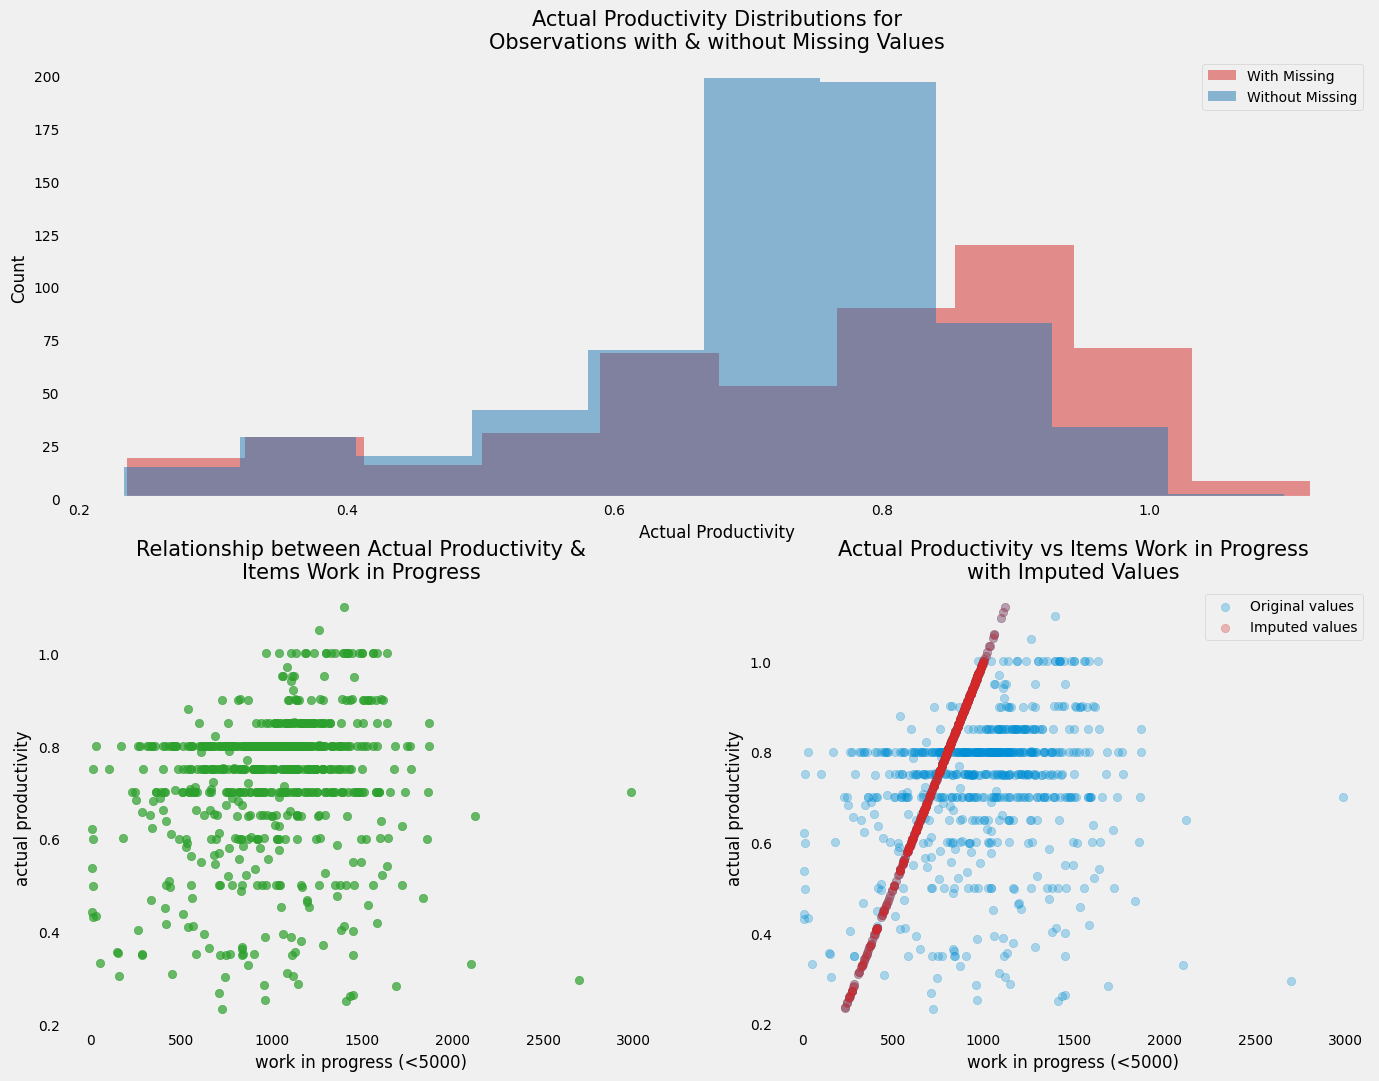

In [377]:
fig = plt.figure(figsize=(15,12))
# Examine values of response variable for the observations with missing values
response_miss = Xy.loc[Xy.isna().sum(axis=1)>0,:]['actual_productivity'] # response for observations with missing values
response_normal = Xy.loc[Xy.isna().sum(axis=1)==0,:]['actual_productivity'] # response for observations with no missing values
fig.add_subplot(2,1,1)
plt.hist(response_miss, alpha=.5, color='tab:red', label='With Missing')
plt.hist(response_normal, alpha=.5, color='tab:blue', label='Without Missing')
plt.legend(fontsize=10)
plt.xlabel("Actual Productivity", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.title("Actual Productivity Distributions for\nObservations with & without Missing Values", fontsize=15)

# Actual productivity vs work in progress
fig.add_subplot(2,2,3)
plt.scatter('wip', 'actual_productivity', data=Xy[Xy['wip']<5000], color='tab:green', alpha=.7)
plt.xlabel("work in progress (<5000)", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("actual productivity", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.title("Relationship between Actual Productivity &\nItems Work in Progress", fontsize=15)

# Show imputed values
index_miss = Xy.loc[Xy.isna().sum(axis=1)>0,:].index
Xy.loc[Xy.isna().sum(axis=1)>0,'wip'] = Xy['actual_productivity'] * 1000 # manual imputation for missing values
fig.add_subplot(2,2,4)
plt.scatter('wip', 'actual_productivity', data=Xy[Xy['wip']<5000], alpha=.3, label="Original values")
plt.scatter('wip', 'actual_productivity', data=Xy.iloc[index_miss,:], color='tab:red', alpha=.3, label="Imputed values")
plt.xlabel("work in progress (<5000)", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("actual productivity", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.legend(loc='upper right', fontsize=10)
plt.title("Actual Productivity vs Items Work in Progress\nwith Imputed Values", fontsize=15)

plt.show()

&emsp;Note that in the scatterplots, a few values of `wip` greater or equal to 5000 are excluded to clearly show the relationship for the majority of the abservations.  

&emsp;In the histogram, the observations with missing values in `wip` have more counts among the top end of `actual_productivity`. Since the number of rows with missing `wip` is accountable, manual imputation based on the visual distribution with data points in green is made to retain the significant amount of information in the dataset. The red data points represent the imputed values for `wip` as shown in the bottom scatterplot.

## Numeric Features<a id='numeric'></a>

In [378]:
# numeric features
nums = ['date', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_workers', 'actual_productivity']
# categorical features
cats = ['quarter', 'department', 'day', 'team', 'no_of_style_change']

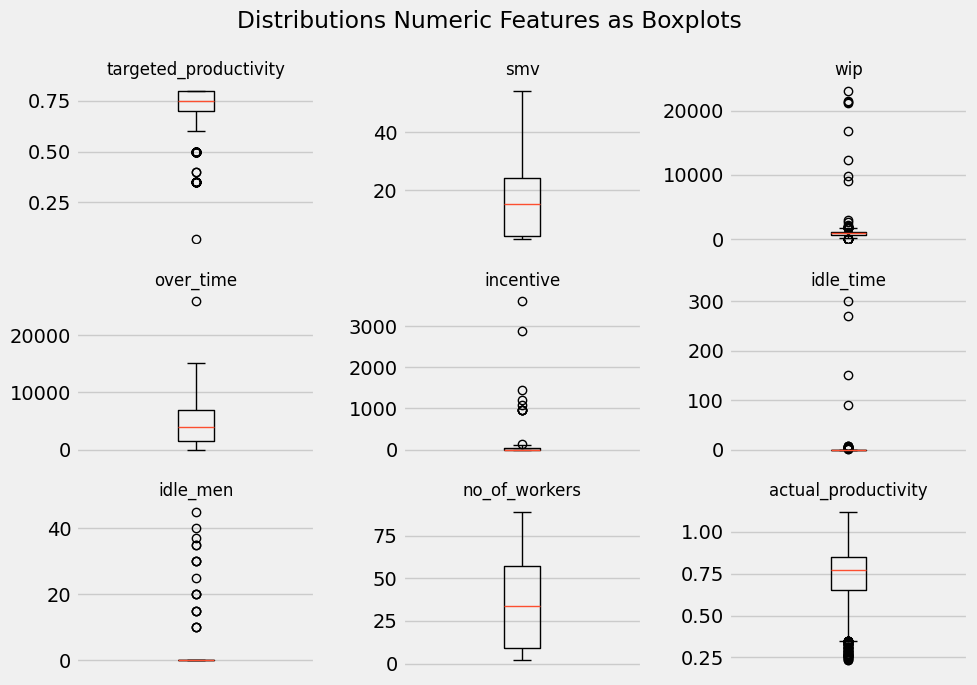

In [379]:
# Relationships between response variable vs numeric features
fig, axes = plt.subplots(3,3, figsize=(10,7))
for i, n in enumerate(nums[1:]):
    ax = axes.ravel()[i]
    ax.boxplot(n, data=Xy, )
    ax.set_xticks([])
    ax.set_title(n, fontsize=12)
fig.suptitle("Distributions Numeric Features as Boxplots")
fig.tight_layout()
plt.show()

&emsp;Many of the numeric features have outliers except for `smv` and `no_of_workers`. They are treated before any further exploration.

### Outliers & Misinformation<a id='outlier'></a>
&emsp;For outliers, I am going to review whether there exists an apparent difference in response variable `actual_productivity` between the outliers and the majority/inliers.

In [441]:
def outlier_exam_numeric(feature):
    '''
    Examination for numeric features with outliers. 
    First, show percentage of outliers.
    Second, display distributions & relationship with response variables.
    
    feature (str): feature in string of the dataset
    
    Return: None
    '''
    # Variables for feature column & response column
    feat = Xy[feature]
    resp = Xy['actual_productivity']
    # Calculate outlier boundaries
    iqr = feat.quantile(.75) - feat.quantile(.25)
    lower_out = feat.quantile(.25) - 1.5*iqr
    upper_out = feat.quantile(.75) + 1.5*iqr
    # Display number of outliers & its portion
    no_outliers = feat[(feat < lower_out) | (feat > upper_out)].shape[0]
    no_total = Xy.shape[0]
    print("Number of outliers:", no_outliers, "out of:", no_total, f"({round(no_outliers/no_total,2)}%)")
    
    # Visualize    
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    axes[0].hist(Xy.loc[~((Xy[feature]<lower_out) | (Xy[feature]>upper_out)), 'actual_productivity'], color='tab:blue', alpha=.5, label='inliers')
    axes[0].hist(Xy.loc[(Xy[feature]<lower_out) | (Xy[feature]>upper_out), 'actual_productivity'], color='tab:red', alpha=.5, label='outliers')
    axes[0].legend(fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].set_ylabel('count', fontsize=10)
    axes[0].set_xlabel('actual_productivity', fontsize=10)
    axes[0].set_title('Distributions of Response Variable Values\nof inliers & outliers', fontsize=12)

    axes[1].scatter(feature, 'actual_productivity', data=Xy.loc[~((Xy[feature]<lower_out) | (Xy[feature]>upper_out)), [feature,'actual_productivity']], color='tab:blue', alpha=.5, label='inliers')
    axes[1].scatter(feature, 'actual_productivity', data=Xy.loc[(Xy[feature]<lower_out) | (Xy[feature]>upper_out), [feature,'actual_productivity']], color='tab:red', alpha=.5, label='outliers')
    axes[1].legend(fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].set_ylabel('actual_productivity', fontsize=10)
    axes[1].set_xlabel(feature, fontsize=10)
    axes[1].set_title(f'Relationship between Response Variable & {feature}', fontsize=12)

    plt.show()

#### `targeted_productivity`

Number of outliers: 79 out of: 1197 (0.07%)


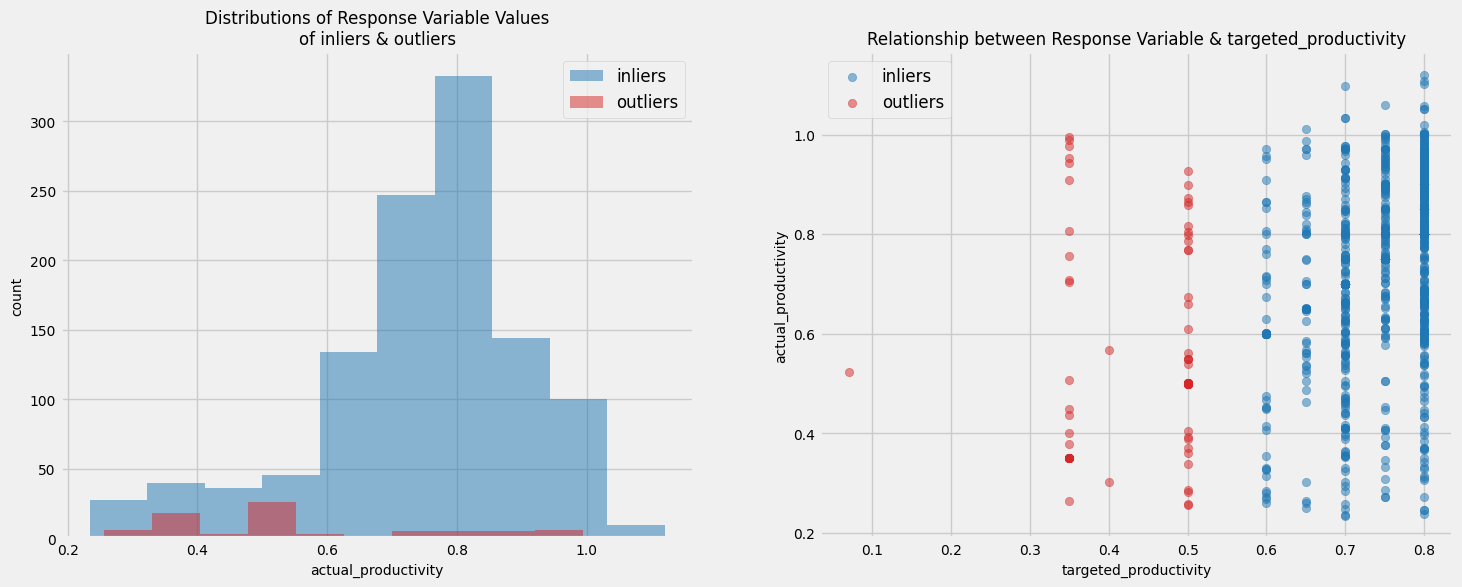

In [445]:
outlier_exam_numeric('targeted_productivity')


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570


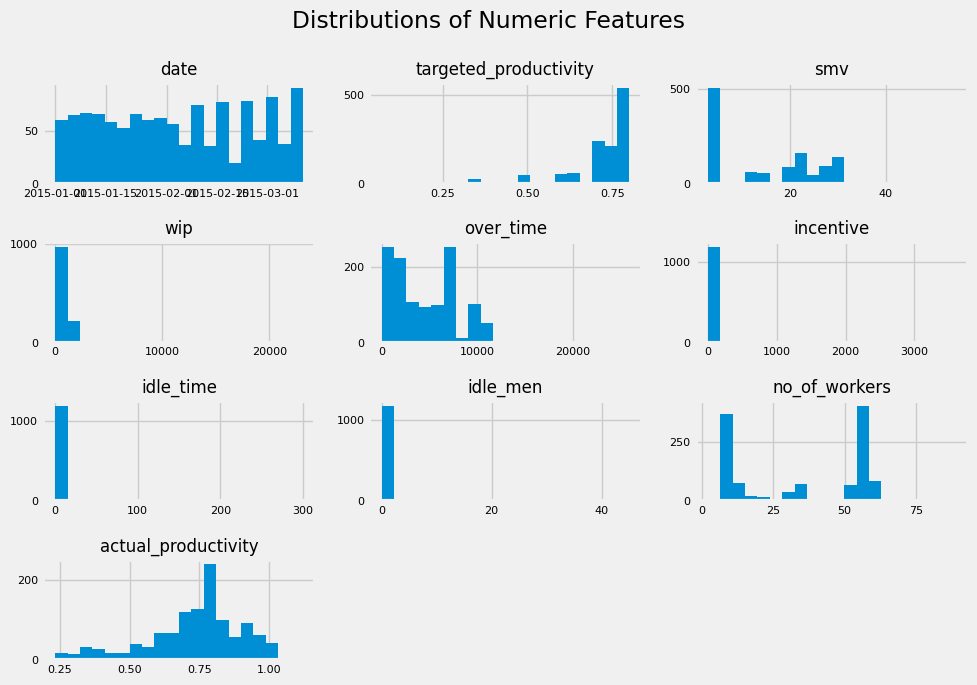

In [380]:
# Begins with distributions in histograms
fig = Xy[nums].hist(figsize=(10,7), xlabelsize=8, ylabelsize=8, bins=20)
[x.title.set_size(12) for x in fig.ravel()]
plt.suptitle("Distributions of Numeric Features")
plt.tight_layout()
plt.show()

&emsp;Most of the numeric variables distributions are not normal except for response variable `actual_productivity` which is slightly left skewed. It may be due to outliers so that majority of data points are stuffed into a bar or a few.

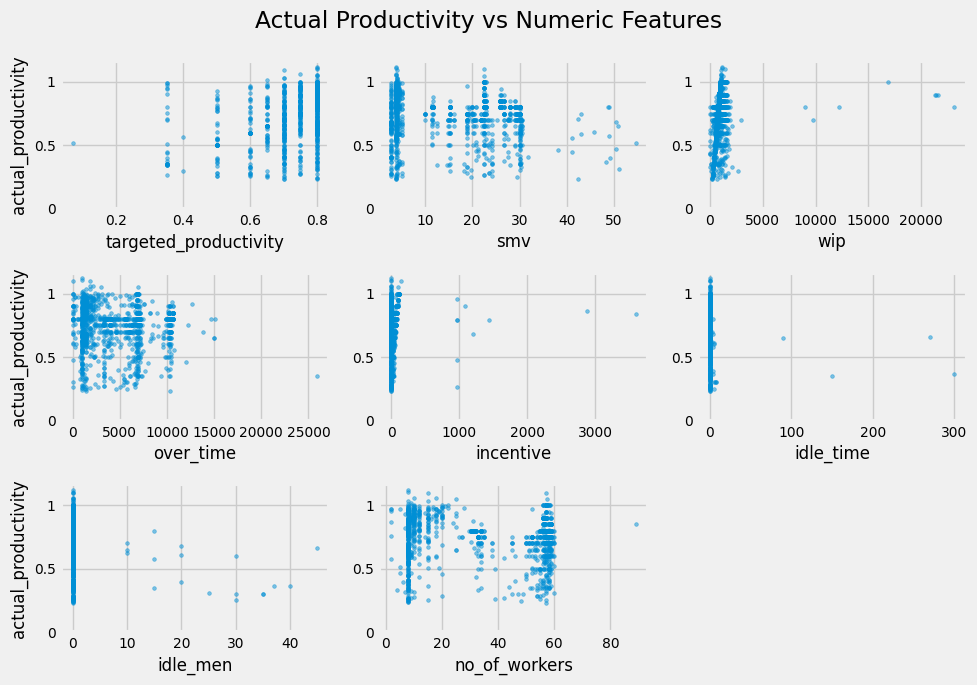

In [381]:
# Relationships between response variable vs numeric features
fig, axes = plt.subplots(3,3, figsize=(10,7))
for i, n in enumerate(nums[1:-1]):
    ax = axes.ravel()[i]
    ax.scatter(n, "actual_productivity", data=Xy, alpha=.5, s=7)
    if i%3 == 0:
        ax.set_ylabel("actual_productivity", fontsize=12)
    ax.set_yticks([0, .5, 1], [0, .5, 1], fontsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_xlabel(n, fontsize=12)
for i in range(len(nums[1:-1]),9):
    ax = axes.ravel()[i]
    ax.set(xticks=[], yticks=[])
fig.suptitle("Actual Productivity vs Numeric Features")
fig.tight_layout()
plt.show()